In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import numpy as np
import sympy
import cirq

%matplotlib inline
from matplotlib import style
style.use('bmh')
style.use('dark_background')

import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [2]:
qubit = cirq.GridQubit(0, 0)

# Define some circuits
circuit1 = cirq.Circuit(cirq.X(qubit))
circuit2 = cirq.Circuit(cirq.H(qubit))

# Convert to a tensor
input_circuit_tensor = tfq.convert_to_tensor([circuit1, circuit2])

# Define a circuit that we want to append
y_circuit = cirq.Circuit(cirq.Y(qubit))

# Instantiate our layer
y_appender = tfq.layers.AddCircuit()

# Run our circuit tensor through the layer and save the output.
output_circuit_tensor = y_appender(input_circuit_tensor, append=y_circuit)

In [3]:
print(tfq.from_tensor(input_circuit_tensor))

[cirq.Circuit([
    cirq.Moment(operations=[
        cirq.X.on(cirq.GridQubit(0, 0)),
    ]),
])
 cirq.Circuit([
    cirq.Moment(operations=[
        cirq.H.on(cirq.GridQubit(0, 0)),
    ]),
])]


In [4]:
print(tfq.from_tensor(output_circuit_tensor))

[cirq.Circuit([
    cirq.Moment(operations=[
        cirq.X.on(cirq.GridQubit(0, 0)),
    ]),
    cirq.Moment(operations=[
        cirq.Y.on(cirq.GridQubit(0, 0)),
    ]),
])
 cirq.Circuit([
    cirq.Moment(operations=[
        cirq.H.on(cirq.GridQubit(0, 0)),
    ]),
    cirq.Moment(operations=[
        cirq.Y.on(cirq.GridQubit(0, 0)),
    ]),
])]


### 1.4 Data

In [5]:
def generate_data(qubits):
    """Generate training and testing data."""
    n_rounds = 20 # Produces n_rounds * n_qubits datapoints
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng).on(bit)))
            labels.append(1 if (-np.pi/2) <= rng <= (np.pi/2) else -1)
            
    split_ind = int(len(excitations) * 0.7)
    train_excitations = excitations[:split_ind]
    test_excitations = excitations[split_ind:]
    
    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]
    
    return tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
                tfq.convert_to_tensor(test_excitations), np.array(test_labels)

In [6]:
sample_points, sample_labels, _, __ = generate_data(cirq.GridQubit.rect(1, 4))
print('Input:', tfq.from_tensor(sample_points)[0], 'Output:', sample_labels[0])
print('Input:', tfq.from_tensor(sample_points)[1], 'Output:', sample_labels[1])

Input: (0, 0): ───Rx(0.482π)─── Output: 1
Input: (0, 1): ───Rx(0.738π)─── Output: -1


### 1.5 Define layers

#### 1.5.1 Cluster state

In [7]:
# The cluster state circuit
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

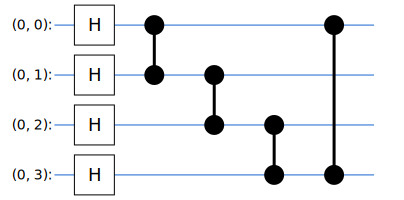

In [8]:
SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(1, 4)))

#### 1.5.2 QCNN layers

In [9]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])

def two_qubit_unitary(bits, symbols):
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[7]]
    circuit += [cirq.YY(*bits)**symbols[8]]
    circuit += [cirq.XX(*bits)**symbols[9]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit

def two_qubit_pool(src_qubit, sink_qubit, symbols):
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    src_basis_selector = one_qubit_unitary(src_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(src_basis_selector)
    pool_circuit.append(cirq.CNOT(src_qubit, sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

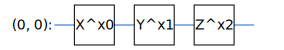

In [10]:
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0), sympy.symbols('x0:3')))

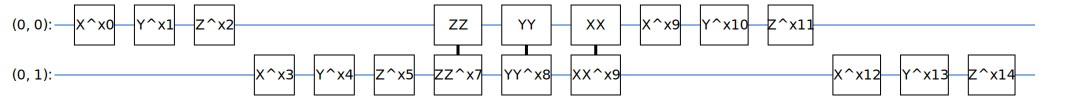

In [11]:
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))

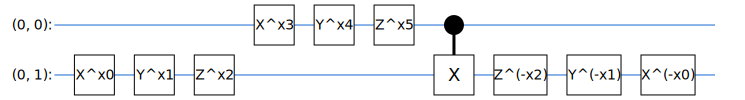

In [12]:
SVGCircuit(two_qubit_pool(*cirq.GridQubit.rect(1, 2), sympy.symbols('x0:6')))

#### 1.5.2.1 Quantum Convolution

In [13]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

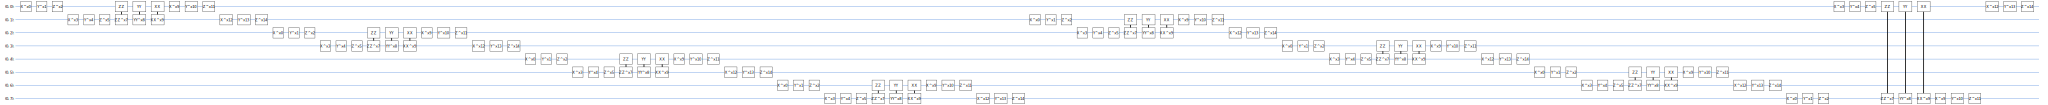

In [14]:
SVGCircuit(quantum_conv_circuit(cirq.GridQubit.rect(1, 8), sympy.symbols('x0:15')))

#### 1.5.2.2 Quantum Pooling

In [15]:
def quantum_pool_circuit(src_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for src, sink in zip(src_bits, sink_bits):
        circuit += two_qubit_pool(src, sink, symbols)
        
    return circuit

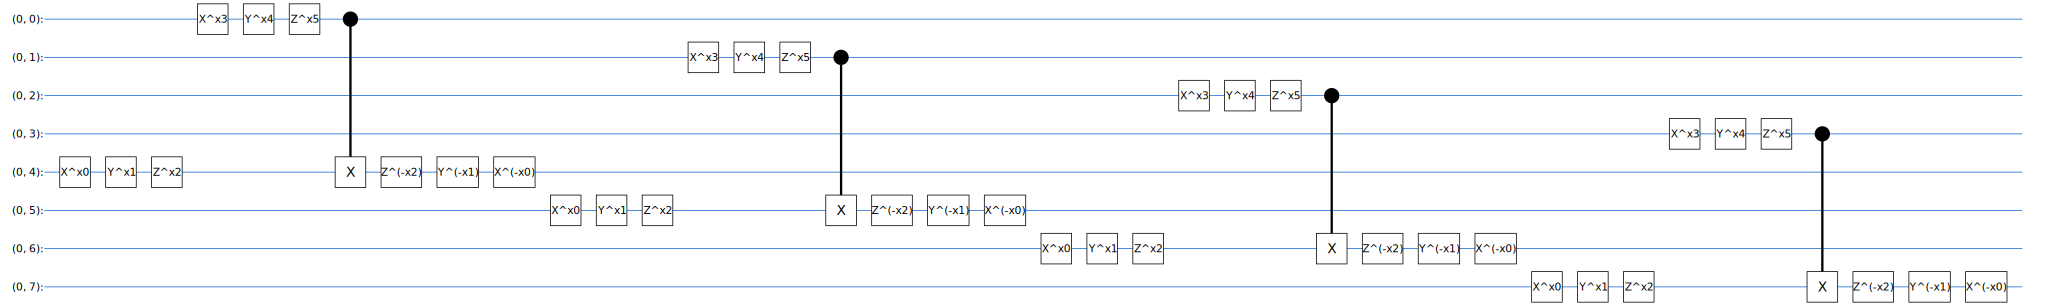

In [16]:
test_bits = cirq.GridQubit.rect(1, 8)

SVGCircuit(quantum_pool_circuit(test_bits[:4], test_bits[4:], sympy.symbols('x0:6')))

### 1.6 Model definition

In [17]:
def create_model_circuit(qubits):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:63')
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:], symbols[15:21])

    model_circuit += quantum_conv_circuit(qubits[4:], symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[4:6], qubits[6:], symbols[36:42])
    
    model_circuit += quantum_conv_circuit(qubits[6:], symbols[42:57])
    model_circuit += quantum_pool_circuit([qubits[6]], [qubits[7]], symbols[57:63])
    
    return model_circuit

# Create our qubits and readout operations in Cirq
cluster_state_bits = cirq.GridQubit.rect(1, 8)
readout_operators = cirq.Z(cluster_state_bits[-1])

# Build a sequential model enacting the logic in 1.3 of this notebook.
# Here you are making the static cluster state prep as a part of the AddCircuit and the
# "quantum datapoints" are coming in the form of excitation
excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
cluster_state = tfq.layers.AddCircuit()(
        excitation_input, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model = tfq.layers.PQC(create_model_circuit(cluster_state_bits), readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

# To show the keras plot of the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


### 1.7 Train the model

In [ ]:
# Generate some training data
train_excitations, train_labels, test_excitations, test_labels = generate_data(cluster_state_bits)

# Custom accuracy metric
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))

qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                  loss=tf.losses.mse,
                  metrics=[custom_accuracy])

history = qcnn_model.fit(x=train_excitations,
                        y=train_labels,
                        batch_size=16,
                        epochs=25,
                        verbose=1,
                        validation_data=(test_excitations, test_labels))

Train on 112 samples, validate on 48 samples
Epoch 1/25


In [ ]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Hybrid Models